In [1]:
from mnist1d.data import make_dataset, ObjectView
from torch import nn
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset

from src.mlp_conversions import sequential_to_mlp
from src.nnet import save_as_nnet
from src.utils import visualize_mnist_1d, plot_training_stats, save_test_dataset

%load_ext autoreload
%autoreload

device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


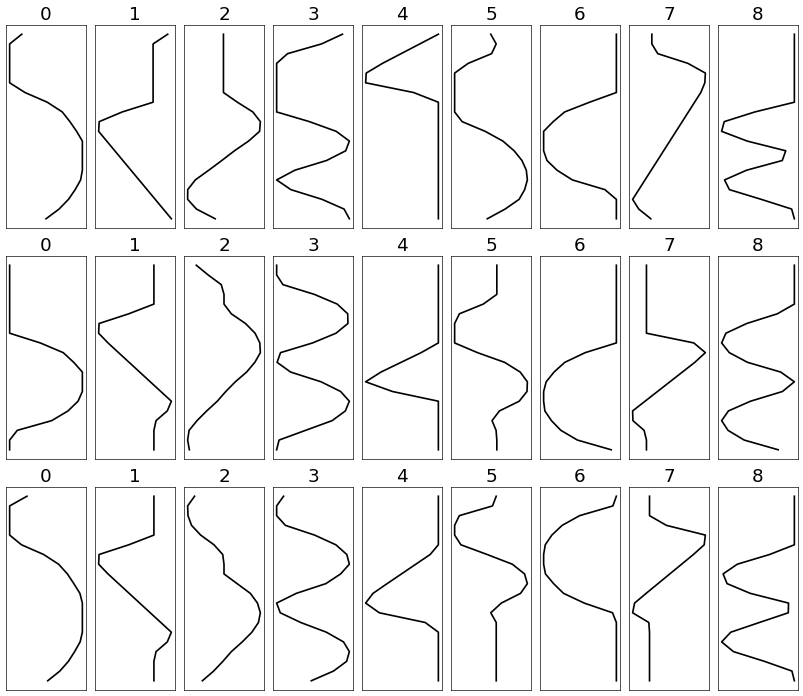

In [2]:
input_size = 20

dataset_args = ObjectView({
    'num_samples': 5000,
    'train_split': 0.8,
    'template_len': 12,
    'padding': [0, 10],
    'scale_coeff': 0,
    'max_translation': 10,
    'corr_noise_scale': 0,
    'iid_noise_scale': 0,
    'shear_scale': 0,
    'shuffle_seq': False,
    'final_seq_length': input_size,
    'seed': 42,
})

data = make_dataset(dataset_args)

visualize_mnist_1d(data['x'], data['y'], data['t'])

In [3]:
x_train = torch.tensor(data['x'], dtype=torch.float32).to(device)
y_train = torch.tensor(data['y'], dtype=torch.long).to(device)
x_test = torch.tensor(data['x_test'], dtype=torch.float32).to(device)
y_test = torch.tensor(data['y_test'], dtype=torch.long).to(device)

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

x_train: torch.Size([4000, 20]), y_train: torch.Size([4000])
x_test: torch.Size([1000, 20]), y_test: torch.Size([1000])


In [4]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv1d(1, 5, 5, stride=5, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(input_size, 10)
        )

    def count_params(self):
        return sum(p.numel() for p in self.parameters())

    def forward(self, x):
        x = x.view(-1, 1, x.shape[-1])
        x = self.layers(x)
        return x


model = CNNModel().to(device)
print(f'parameters: {model.count_params()}')
print(model)

x_batch = x_train[:8]
output = model(x_batch)

parameters: 240
CNNModel(
  (layers): Sequential(
    (0): Conv1d(1, 5, kernel_size=(5,), stride=(5,))
    (1): ReLU()
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=20, out_features=10, bias=True)
  )
)


100%|██████████| 20/20 [00:00<00:00, 21.77it/s, train_loss=0.7602, val_acc=0.7810]


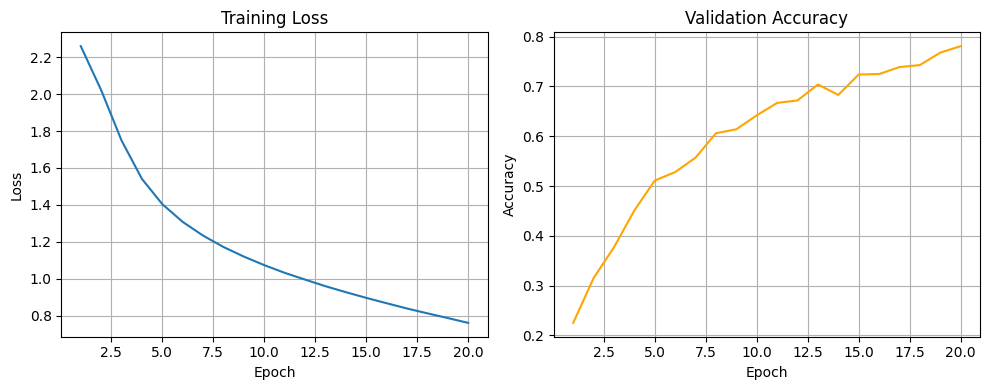

In [5]:
batch_size = 64
num_epochs = 20

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
val_accuracies = []

epoch_bar = tqdm(range(num_epochs))
for epoch in epoch_bar:
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        logits = model(xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)

    model.eval()
    with torch.no_grad():
        preds = model(x_test).argmax(dim=1)
        val_acc = (preds == y_test).float().mean().item()
        val_accuracies.append(val_acc)

    epoch_bar.set_postfix({"train_loss": f"{avg_loss:.4f}", "val_acc": f"{val_acc:.4f}"})

plot_training_stats(train_losses, val_accuracies)

In [6]:
%autoreload

# Convert the model to MLP
model_mlp = sequential_to_mlp(model.layers, input_size)

# Verify that the MLP model has the same accuracy
preds = model_mlp(x_test).argmax(dim=1)
mlp_test_acc = (preds == y_test).float().mean().item()
print(f"MLP test accuracy: {mlp_test_acc:.4f}")

MLP test accuracy: 0.7810


In [7]:
%autoreload

save_as_nnet(model_mlp, f"model_mlp.nnet")

save_test_dataset(x_test, y_test, preds.cpu().numpy(), "test_dataset.txt", num_samples=10)